In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import sys
sys.path.append('/home/midzay/Mlerning/bigartm/python')
import artm
import warnings
warnings.filterwarnings('ignore')


from ast import literal_eval
from tqdm import tqdm
from datetime import datetime as time


In [2]:
PATH = 'data/all/'

In [3]:
files = list(os.walk(PATH))[0][2]

In [4]:
file=files[0]
df = pd.read_csv(PATH+file)
#df = df[df.text!='text']
print(df.shape)
df.head(2)

(50856, 6)


,date,topic,text,predict,text_new,lemmatized_text
0,1999-10-01 12:00:00,Россия,"1 октября в Москве в отеле ""Аэростар"" открылас...",Интернет и СМИ,октября в москве в отеле аэростар открылась пе...,"['москва', 'отель', 'аэростарый', 'открыться',..."
1,1999-10-01 12:00:00,Мир,"Украинский порнографический сайт занял домен, ...",Интернет и СМИ,украинский порнографический сайт занял домен р...,"['украинский', 'порнографический', 'сайт', 'за..."


In [5]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

* get dates

In [6]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head(2)

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,1999-10-01 12:00:00,Россия,"1 октября в Москве в отеле ""Аэростар"" открылас...",Интернет и СМИ,октября в москве в отеле аэростар открылась пе...,"[москва, отель, аэростарый, открыться, московс...",1999,10
1,1999-10-01 12:00:00,Мир,"Украинский порнографический сайт занял домен, ...",Интернет и СМИ,украинский порнографический сайт занял домен р...,"[украинский, порнографический, сайт, занять, д...",1999,10


* add docID

In [7]:
df['docID'] = list(range(df.shape[0]))
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[москва, отель, аэростарый, открыться, московс..."
1,1,1999,10,"[украинский, порнографический, сайт, занять, д..."


In [8]:
print(df.shape)
df.isnull().sum()

(50856, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

* look at unique dates

In [9]:
df_data = df[['year','month']]
print(df_data.shape)
df_data.head(2)

(50856, 2)


,year,month
0,1999,10
1,1999,10


In [10]:
select_topics = 15

In [12]:
vwpath= f'data/vwpath/{file}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

In [13]:
id_date = df[['docID', 'year', 'month']].copy()

In [14]:
batches_path = f'data/batches/{file}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                              data_format='vowpal_wabbit',
                                              target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/Internet_i_SMI.csv.bz2", num_batches=51)


In [15]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=648b1f11-7594-405c-9c19-4257140e5fa7, num_entries=26626)

In [16]:
%%time
model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

print(f"\tSparsityThetaScore: {model.score_tracker['SparsityThetaScore'].last_value}")
print(f"\tSparsityPhiScore: {model.score_tracker['SparsityPhiScore'].last_value}")
print(f"\tPerplexityScore: {model.score_tracker['PerplexityScore'].last_value}")


	SparsityThetaScore: 0.5644224286079407
	SparsityPhiScore: 0.84550940990448
	PerplexityScore: 707.2867431640625
CPU times: user 11min 4s, sys: 3.89 s, total: 11min 8s
Wall time: 3min 29s


* print top words for each topics

In [55]:
phi = model.get_phi()
phi['word'] = phi.index
phi['word']=phi.word.apply(lambda x: x[1])

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")

topic_0: ['google' 'яндекс' 'приложение' 'microsoft' 'поисковый' 'компьютер'
 'apple' 'устройство' 'yahoo' 'запрос']
topic_1: ['иск' 'эхо' 'радиостанция' 'нтв' 'гендиректор' 'холдинг' 'генеральный'
 'коммерсант' 'акция' 'акционер']
topic_2: ['британский' 'великобритания' 'bbc' 'китайский' 'бибись' 'news' 'китай'
 'исследование' 'житель' 'телефон']
topic_3: ['миллиард' 'рынок' 'реклама' 'рубль' 'составить' 'доля' 'услуга'
 'рекламный' 'развитие' 'аудитория']
topic_4: ['роскомнадзор' 'ведомство' 'требование' 'блокировка' 'законопроект'
 'запретить' 'нарушение' 'документ' 'госдума' 'законодательство']
topic_5: ['украина' 'премия' 'корреспондент' 'украинский' 'номинация' 'убийство'
 'задержать' 'журналистка' 'произойти' 'здание']
topic_6: ['ролик' 'реклама' 'фильм' 'youtube' 'рекламный' 'видео' 'игра' 'шоу'
 'сериал' 'трансляция']
topic_7: ['атака' 'хакер' 'безопасность' 'взлом' 'хакерский' 'взломать' 'документ'
 'спецслужба' 'военный' 'wikileaks']
topic_8: ['интервью' 'new' 'дождь' 'york'

In [56]:
theta = model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T

theta.head(2)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
44000,0.0,0.348036,0.0,0.000000,0.0,0.004120,0.047315,0.0,0.000000,0.000000,0.039251,0.0,0.561278,0.000000,0.0
44001,0.0,0.000000,0.0,0.191479,0.0,0.032948,0.000000,0.0,0.312243,0.119452,0.315442,0.0,0.000000,0.028436,0.0


In [57]:
joined = id_date.join(theta)
joined.head(2)

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0,1999,10,0.105467,0.0,0.000000,0.537372,0.0,0.0,0.218052,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.13911,0.000000
1,1,1999,10,0.219644,0.0,0.162097,0.052522,0.0,0.0,0.000000,0.0,0.111671,0.0,0.320401,0.0,0.052321,0.00000,0.081343


In [58]:
joined.tail()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
50851,50851,2019,1,0.307348,0.000000,0.000000,0.000000,0.000000,0.193251,0.000000,0.000000,0.00000,0.212811,0.000000,0.00000,0.0,0.038745,0.247845
50852,50852,2019,1,0.000000,0.160839,0.055708,0.086754,0.286263,0.136163,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.274274
50853,50853,2019,1,0.317865,0.009551,0.032989,0.124425,0.089026,0.004273,0.000000,0.162720,0.01817,0.017075,0.000000,0.15611,0.0,0.000000,0.067795
50854,50854,2019,1,0.340780,0.000000,0.000000,0.358245,0.247413,0.000000,0.000000,0.000000,0.00000,0.000000,0.010071,0.00000,0.0,0.000000,0.043491
50855,50855,2019,1,0.000000,0.000000,0.033068,0.000000,0.000000,0.531109,0.023229,0.178285,0.00000,0.012089,0.089534,0.00000,0.0,0.057096,0.075590


In [59]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()

print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (233, 15)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 9      2.552692  2.295661  1.256191  2.363887  3.822048  2.105959   
     10     5.890912  2.607384  3.344784  9.784241  5.599824  1.522914   
     11     7.202803  4.057702  3.484487  7.319239  7.654174  3.322113   
     12     7.090250  4.979550  3.171340  7.213368  5.857589  2.233647   
2000 1      9.698079  2.194226  3.381704  4.615067  6.824971  2.791087   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 9      0.800390  3.666866  1.626524  1.325907  5.127652  0.548635   
     10     2.079225  2.594928  1.754653  1.082574  4.857367  0.085918   
     11     1.723276  3.822964  1.575706  1.795684  5.301823  0.715932   
     12     1.318210  5.973240  1.966022  1.308203  6.486635  1.076014   
2000 1      1.649383  6.993295  2.079566  2.245412  5.973122  1.238499   

            topic_12  topic_13  topic_14  
year month                                
1999 9      1.307227  2.676464  2.523898  
     10     1.249274  3.628034  2.917968  
     11     2.209721  7.894013  3.920364  
     12     1.914651  5.997617  2.413663  
2000 1      2.029531  5.453626  1.832431

* joypy

In [60]:
import joypy # !pip install joypy

In [61]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,date
0,0,1999,10,0.105467,0.0,0.000000,0.537372,0.000000,0.000000,0.218052,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.139110,0.000000,1999-10-01
1,1,1999,10,0.219644,0.0,0.162097,0.052522,0.000000,0.000000,0.000000,0.000000,0.111671,0.000000,0.320401,0.0,0.052321,0.000000,0.081343,1999-10-01
2,2,1999,10,0.654033,0.0,0.000000,0.150806,0.000000,0.000000,0.022302,0.000000,0.000000,0.069022,0.000000,0.0,0.056316,0.047521,0.000000,1999-10-01
3,3,1999,10,0.000000,0.0,0.056190,0.000000,0.077603,0.295979,0.000000,0.296492,0.229334,0.000000,0.021006,0.0,0.000000,0.023395,0.000000,1999-10-01
4,4,1999,10,0.000000,0.0,0.000000,0.369635,0.086173,0.000000,0.000000,0.000000,0.000000,0.000000,0.544192,0.0,0.000000,0.000000,0.000000,1999-10-01


In [62]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()
dd2=dd2.reset_index()

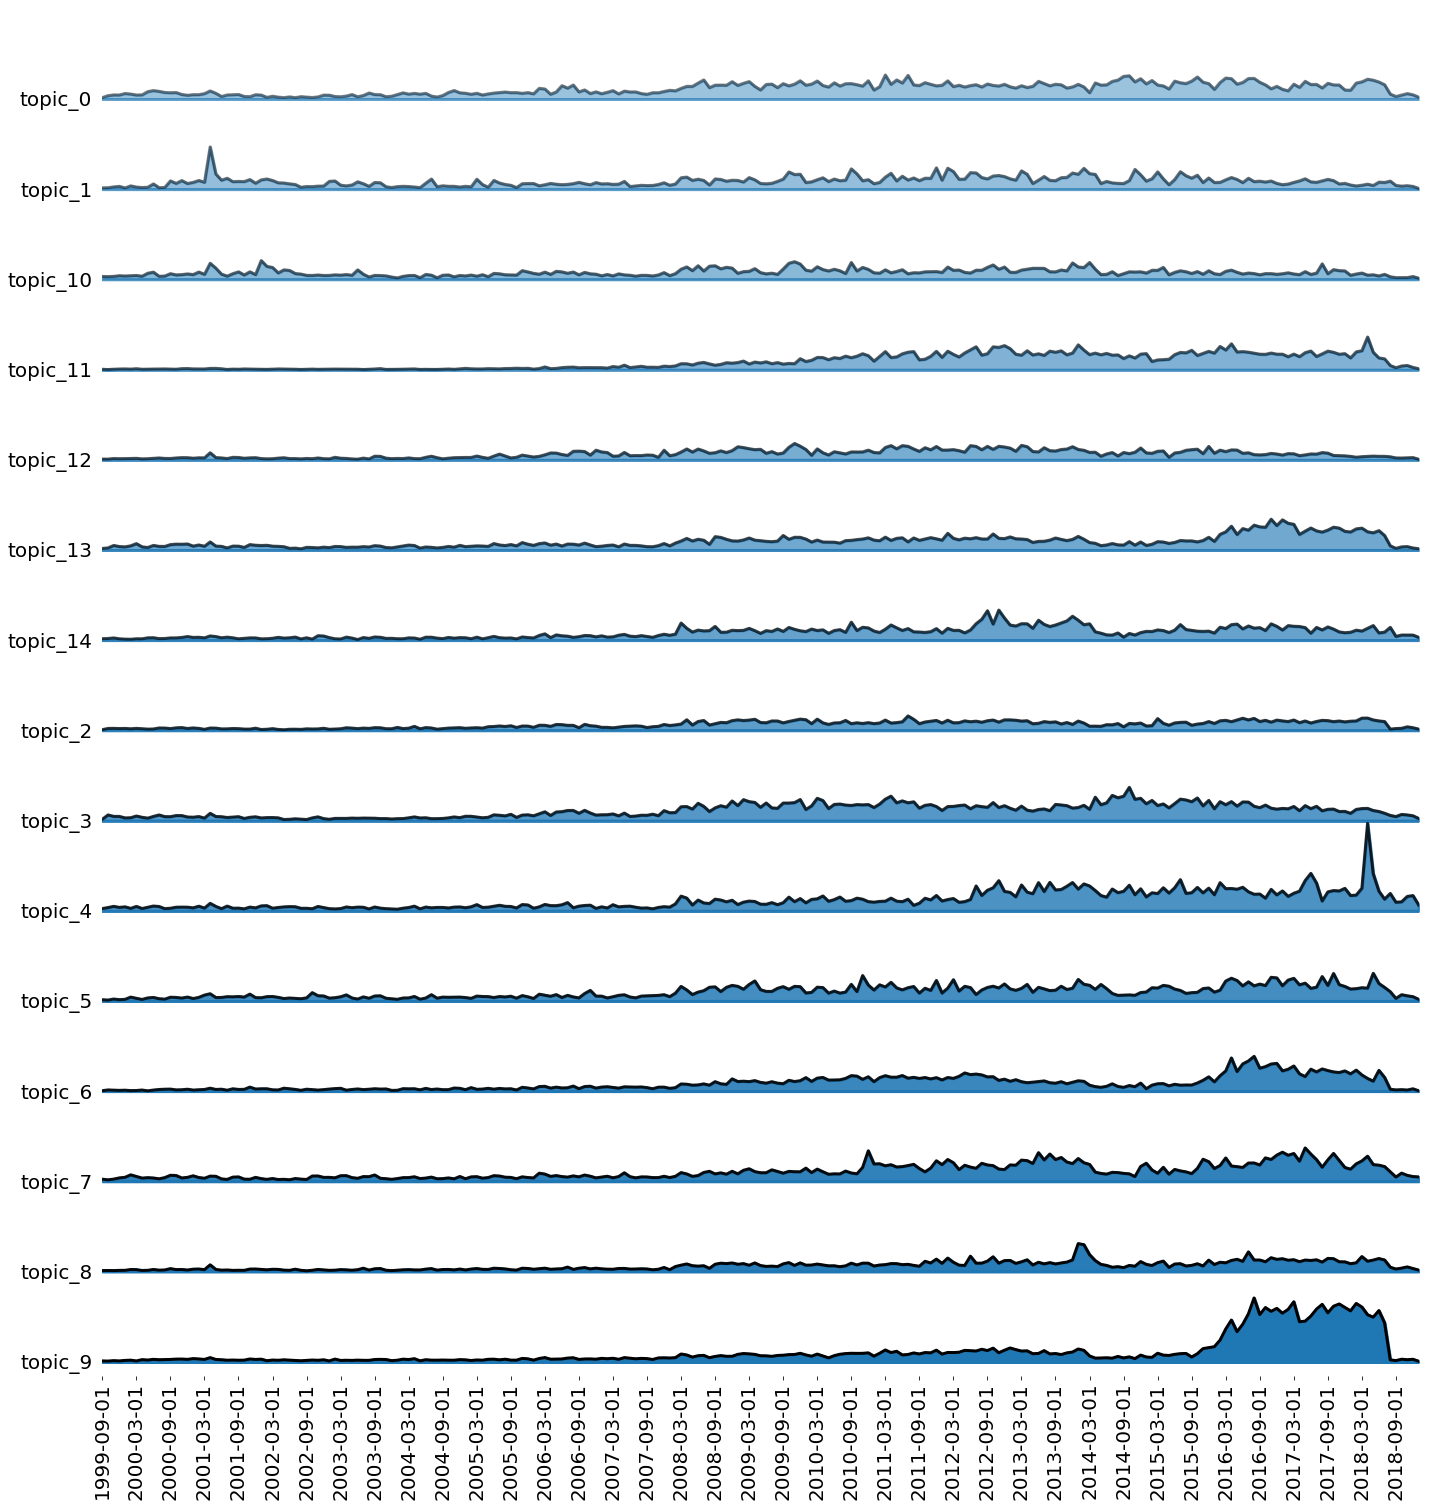

In [64]:
labels = sorted(joined['date'].unique())
fig_interfax, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

Интерфакс начинается с 2008 года. Поэтому такое затишье вначале

In [236]:
#fig_interfax.savefig(f"data/interfax/interfax_{'-'.join(name_dataset_interfax.split('.'))}_joypy")